In [1]:
import os
import tensorflow as tf

from tensorflow.keras import models ,layers
import matplotlib.pyplot as plt
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 20
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    r"C:\Users\moumita\Desktop\6th Semester\DL_Project\dset",
    shuffle =True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 20638 files belonging to 15 classes.


In [2]:
class_names= dataset.class_names
class_names

['Pepper__bell___Bacterial_spot',
 'Pepper__bell___healthy',
 'Potato___Early_blight',
 'Potato___Late_blight',
 'Potato___healthy',
 'Tomato_Bacterial_spot',
 'Tomato_Early_blight',
 'Tomato_Late_blight',
 'Tomato_Leaf_Mold',
 'Tomato_Septoria_leaf_spot',
 'Tomato_Spider_mites_Two_spotted_spider_mite',
 'Tomato__Target_Spot',
 'Tomato__Tomato_YellowLeaf__Curl_Virus',
 'Tomato__Tomato_mosaic_virus',
 'Tomato_healthy']

In [3]:
len(dataset)

645

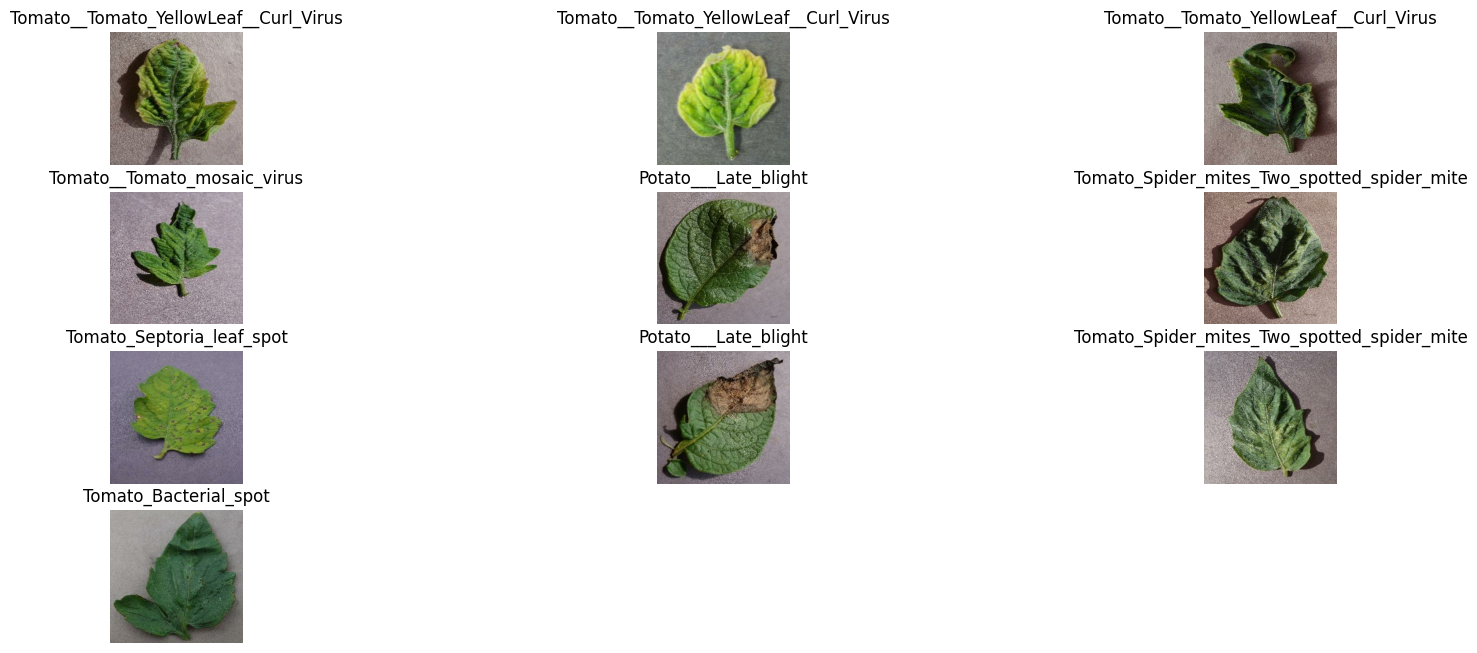

In [4]:
plt.figure(figsize=(20, 10))
for image_batch, label_batch in dataset.take(1):
    for i in range(10):
        ax = plt.subplot(5,3, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        label_index = label_batch[i].numpy()
        class_name = class_names[label_index] 
        plt.title(class_name)
        plt.axis("off")
plt.show()

In [5]:
import tensorflow as tf

def split_dataset(ds, train_ratio=0.8, val_ratio=0.1, test_ratio=0.1, shuffle=True, buffer_size=10000):
    ds_size = len(ds)
    if shuffle:
        ds = ds.shuffle(buffer_size, seed=42)
    train_size = int(train_ratio * ds_size)
    val_size = int(val_ratio * ds_size)
    
    train_ds = ds.take(train_size)
    remaining_ds = ds.skip(train_size)
    val_ds = remaining_ds.take(val_size)
    test_ds = remaining_ds.skip(val_size)
    
    return train_ds, val_ds, test_ds

train_ds, val_ds, test_ds = split_dataset(dataset)

In [6]:
train_ds = dataset.take(516)
len(train_ds)

516

In [7]:
temp_test_ds = dataset.skip(516)
len(temp_test_ds)

129

In [8]:
val_size = 0.1
len(dataset) * val_size

64.5

In [9]:
val_ds = temp_test_ds.take(64)
len(val_ds)

64

In [10]:
test_ds = temp_test_ds.skip(64)
len(test_ds)

65

In [11]:
def preprocess_image(image, label):
    image = tf.image.resize(image, (224, 224))
    return image, label
train_ds = train_ds.map(preprocess_image)
val_ds = val_ds.map(preprocess_image)

In [12]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.Rescaling(1.0 / 255)
])

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
])

In [13]:
n_classes = 15
IMAGE_SIZE = 256
CHANNELS = 3
rescale_factor = 1.0 / 255.0

In [14]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam

base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
base_model.trainable = False
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(15, activation='softmax')(x)

In [15]:
model = Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer=Adam(learning_rate=0.0001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [16]:
for layer in model.layers:
    layer.trainable = True

In [17]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)       ┃ Output Shape     ┃   Param # ┃ Connected to     ┃
┡━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ input_layer        │ (None, 224, 224, │         0 │ -                │
│ (InputLayer)       │ 3)               │           │                  │
├────────────────────┼──────────────────┼───────────┼──────────────────┤
│ conv1_pad          │ (None, 230, 230, │         0 │ input_layer[0][… │
│ (ZeroPadding2D)    │ 3)               │           │                  │
├────────────────────┼──────────────────┼───────────┼──────────────────┤
│ conv1_conv         │ (None, 112, 112, │     9,472 │ conv1_pad[0][0]  │
│ (Conv2D)           │ 64)              │           │                  │
├────────────────────┼──────────────────┼───────────┼──────────────────┤
│ conv1_bn           │ (None, 112, 112, │       256 │ conv1_conv[0][0] │
│ (BatchNormalizati… │ 64)              │           │                  │
├────────────────────┼──────────────────┼───────────┼──────────────────┤
│ conv1_relu         │ (None, 112, 112, │         0 │ conv1_bn[0][0]   │
│ (Activation)       │ 64)              │           │                  │
├────────────────────┼──────────────────┼───────────┼──────────────────┤
│ pool1_pad          │ (None, 114, 114, │         0 │ conv1_relu[0][0] │
│ (ZeroPadding2D)    │ 64)              │           │                  │
├────────────────────┼──────────────────┼───────────┼──────────────────┤
│ pool1_pool         │ (None, 56, 56,   │         0 │ pool1_pad[0][0]  │
│ (MaxPooling2D)     │ 64)              │           │                  │
├────────────────────┼──────────────────┼───────────┼──────────────────┤
│ conv2_block1_1_co… │ (None, 56, 56,   │     4,160 │ pool1_pool[0][0] │
│ (Conv2D)           │ 64)              │           │                  │
├────────────────────┼──────────────────┼───────────┼──────────────────┤
│ conv2_block1_1_bn  │ (None, 56, 56,   │       256 │ conv2_block1_1_… │
│ (BatchNormalizati… │ 64)              │           │                  │
├────────────────────┼──────────────────┼───────────┼──────────────────┤
│ conv2_block1_1_re… │ (None, 56, 56,   │         0 │ conv2_block1_1_… │
│ (Activation)       │ 64)              │           │                  │
├────────────────────┼──────────────────┼───────────┼──────────────────┤
│ conv2_block1_2_co… │ (None, 56, 56,   │    36,928 │ conv2_block1_1_… │
│ (Conv2D)           │ 64)              │           │                  │
├────────────────────┼──────────────────┼───────────┼──────────────────┤
│ conv2_block1_2_bn  │ (None, 56, 56,   │       256 │ conv2_block1_2_… │
│ (BatchNormalizati… │ 64)              │           │                  │
├────────────────────┼──────────────────┼───────────┼──────────────────┤
│ conv2_block1_2_re… │ (None, 56, 56,   │         0 │ conv2_block1_2_… │
│ (Activation)       │ 64)              │           │                  │
├────────────────────┼──────────────────┼───────────┼──────────────────┤
│ conv2_block1_0_co… │ (None, 56, 56,   │    16,640 │ pool1_pool[0][0] │
│ (Conv2D)           │ 256)             │           │                  │
├────────────────────┼──────────────────┼───────────┼──────────────────┤
│ conv2_block1_3_co… │ (None, 56, 56,   │    16,640 │ conv2_block1_2_… │
│ (Conv2D)           │ 256)             │           │                  │
├────────────────────┼──────────────────┼───────────┼──────────────────┤
│ conv2_block1_0_bn  │ (None, 56, 56,   │     1,024 │ conv2_block1_0_… │
│ (BatchNormalizati… │ 256)             │           │                  │
├────────────────────┼──────────────────┼───────────┼──────────────────┤
│ conv2_block1_3_bn  │ (None, 56, 56,   │     1,024 │ conv2_block1_3_… │
│ (BatchNormalizati… │ 256)             │           │                  │
├────────────────────┼──────────────────┼───────────┼──────────────────┤
│ conv2_block1_add   │ (None, 56, 56,   │         0 │ conv

 Total params: 25,701,263 (98.04 MB)

 Trainable params: 25,648,143 (97.84 MB)

 Non-trainable params: 53,120 (207.50 KB)

In [18]:
history = model.fit(train_ds, epochs=EPOCHS, validation_data=val_ds, verbose=1)

Epoch 1/20
516/516 ━━━━━━━━━━━━━━━━━━━━ 4045s 8s/step - accuracy: 0.8610 - loss: 0.4609 - val_accuracy: 0.9604 - val_loss: 0.1221
Epoch 2/20
516/516 ━━━━━━━━━━━━━━━━━━━━ 3905s 8s/step - accuracy: 0.9848 - loss: 0.0483 - val_accuracy: 0.9785 - val_loss: 0.0747
Epoch 3/20
516/516 ━━━━━━━━━━━━━━━━━━━━ 3617s 7s/step - accuracy: 0.9880 - loss: 0.0354 - val_accuracy: 0.9741 - val_loss: 0.0795
Epoch 4/20
516/516 ━━━━━━━━━━━━━━━━━━━━ 3613s 7s/step - accuracy: 0.9892 - loss: 0.0325 - val_accuracy: 0.9438 - val_loss: 0.3036
Epoch 5/20
516/516 ━━━━━━━━━━━━━━━━━━━━ 3691s 7s/step - accuracy: 0.9890 - loss: 0.0342 - val_accuracy: 0.9448 - val_loss: 0.3223
Epoch 6/20
516/516 ━━━━━━━━━━━━━━━━━━━━ 3669s 7s/step - accuracy: 0.9945 - loss: 0.0194 - val_accuracy: 0.9849 - val_loss: 0.0576
Epoch 7/20
516/516 ━━━━━━━━━━━━━━━━━━━━ 3558s 7s/step - accuracy: 0.9922 - loss: 0.0255 - val_accuracy: 0.9858 - val_loss: 0.0621
Epoch 8/20
516/516 ━━━━━━━━━━━━━━━━━━━━ 3458s 7s/step - accuracy: 0.9957 - loss: 0.0137 - 

In [19]:
score = model.evaluate(test_ds)
print(f"Test Loss: {score[0]}")
print(f"Test Accuracy: {score[1]}")


65/65 ━━━━━━━━━━━━━━━━━━━━ 170s 2s/step - accuracy: 0.9752 - loss: 0.0786
Test Loss: 0.07708816230297089
Test Accuracy: 0.9754571914672852


In [20]:
print(f"Test Accuracy: {score[1] * 100:.2f}%")

Test Accuracy: 97.55%


In [21]:
history.params

{'verbose': 1, 'epochs': 20, 'steps': 516}

In [22]:
history.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

In [25]:
# Save the model
directory=r"C:\Users\moumita\Desktop\6th Semester\DL_Project"
# Get a list of all files in the directory
files = os.listdir(directory)

# Extract the numeric part of each filename
file_numbers = [int(i.split('.')[0]) for i in files if i.split('.')[0].isdigit()]

# Find the maximum version number and increment by 1
max_version = max(file_numbers) + 1 if file_numbers else 1
model.save(f"{directory}/{max_version}.keras")


In [26]:
acc = history.history['accuracy']
print("Training Accuracy:", acc)
print("Accuracy Length: ",len(acc))
val_acc = history.history['val_accuracy']
print("Validation Accuracy:", val_acc)
loss = history.history['loss']
print("Training Loss:", loss)
val_loss = history.history['val_loss']
print("Validation Loss:", val_loss)

Training Accuracy: [0.9342902302742004, 0.9845566749572754, 0.9906128644943237, 0.9878270626068115, 0.9903100728988647, 0.9950339198112488, 0.9917635917663574, 0.9954578280448914, 0.9948522448539734, 0.9945493936538696, 0.9933381676673889, 0.9961845874786377, 0.9952155947685242, 0.9942466020584106, 0.9978197813034058, 0.996911346912384, 0.9983648061752319, 0.9961845874786377, 0.9964268207550049, 0.9983042478561401]
Accuracy Length:  20
Validation Accuracy: [0.96044921875, 0.978515625, 0.97412109375, 0.94384765625, 0.94482421875, 0.98486328125, 0.98583984375, 0.99365234375, 0.984375, 0.98876953125, 0.98486328125, 0.982421875, 0.9814453125, 0.974609375, 0.99169921875, 0.9931640625, 0.99365234375, 0.98388671875, 0.95947265625, 0.984375]
Training Loss: [0.213694766163826, 0.049836255609989166, 0.028554832562804222, 0.037030577659606934, 0.03084087185561657, 0.016540609300136566, 0.02530232071876526, 0.014441131614148617, 0.015679487958550453, 0.015832863748073578, 0.018816014751791954, 0.0

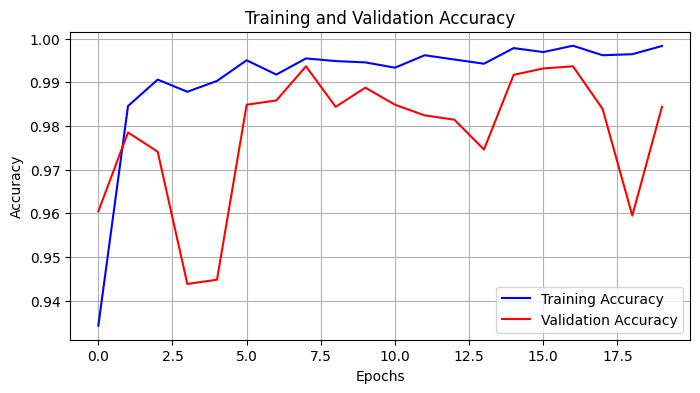

In [27]:
#Accuracy
epochs_range = range(len(acc))
plt.figure(figsize=(8, 4))
plt.plot(epochs_range, acc, label='Training Accuracy', color='blue')
plt.plot(epochs_range, val_acc, label='Validation Accuracy', color='red')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.grid(True)
plt.show()

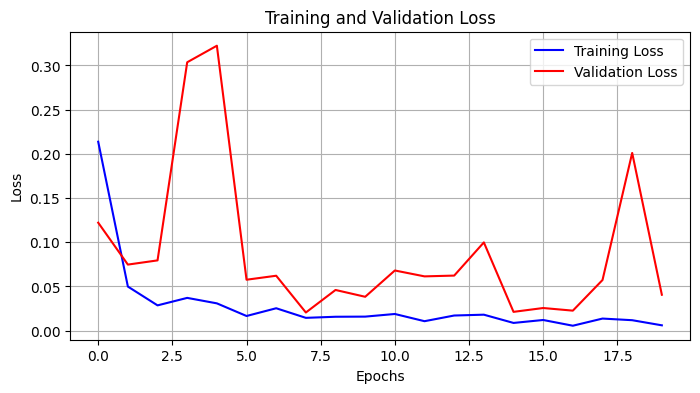

In [28]:
# Loss
plt.figure(figsize=(8, 4))

plt.plot(epochs_range, loss, label='Training Loss', color='blue')
plt.plot(epochs_range, val_loss, label='Validation Loss', color='red')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

In [42]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
import numpy as np
def preprocess_image(image, label):
    image = tf.image.resize(image, (224, 224))
    return image, label
temp_test_ds = temp_test_ds.map(preprocess_image)
y_true = []
y_pred = []
for images, labels in temp_test_ds:
    y_true.extend(labels.numpy())  # Extend the true labels list
    predictions = model.predict(images)
    y_pred.extend(np.argmax(predictions, axis=1))  # Extend the predicted labels list

# Calculate the metrics
accuracy = accuracy_score(y_true, y_pred)
print("Accuracy:", accuracy)
precision = precision_score(y_true, y_pred, average='macro')
print("Precision:", precision)
recall = recall_score(y_true, y_pred, average='macro')
print("Recall:", recall)
f1 = f1_score(y_true, y_pred, average='macro')
print("F1 Score:", f1)
cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix: \n", cm)

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 682ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 292ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 274ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step


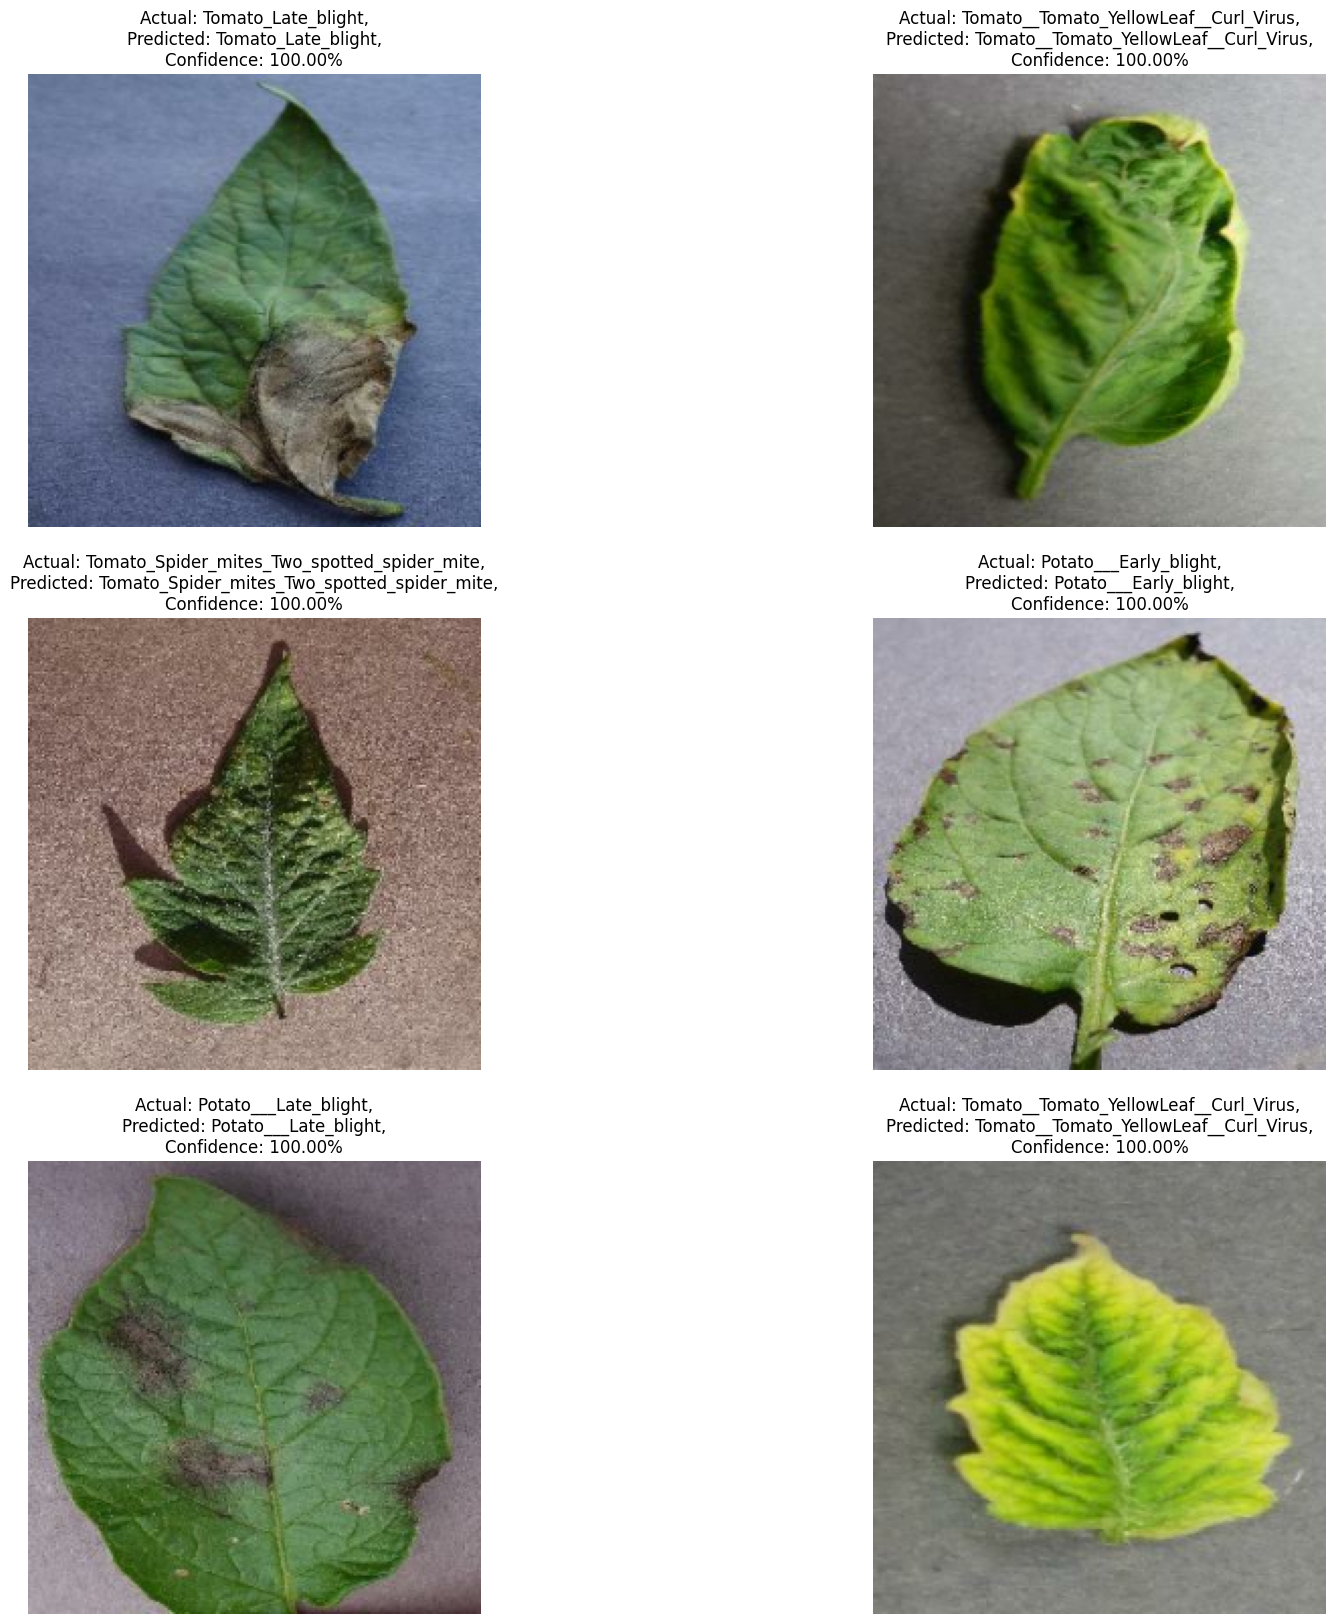

In [52]:
import matplotlib.pyplot as plt
import numpy as np

plt.figure(figsize=(20,20))

for images, labels in test_ds.take(1):  
    for i in range(6): 
        ax = plt.subplot(3, 2, i+1)
        plt.imshow(images[i].numpy().astype("uint8"))

        
        predictions = model.predict(np.expand_dims(images[i], axis=0))  
        predicted_class = class_names[np.argmax(predictions)]  
        confidence = np.max(predictions) * 100  

        
        actual_class = class_names[labels[i].numpy()]

        plt.title(f"Actual: {actual_class},\nPredicted: {predicted_class},\nConfidence: {confidence:.2f}%")
        plt.axis("off")

    plt.show()
